In [201]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from tqdm.notebook import tqdm
from IPython.display import clear_output

plt.rcParams.update({'font.size': 16})
sns.set_style('whitegrid')
np.random.seed(0xFA1AFE1)
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [202]:
df = pd.read_csv('expanded_data_with_OSM.csv', sep = ',')

In [203]:
#два пропущенных региона - это южный федеральный округ
df['regions'] = df['regions'].replace(np.nan, 'Southern Federal District')

In [204]:
#добавляю таргет переменную
df2 = pd.read_csv('Данные/train.csv')
df_train = df.merge(df2[['id','target']], left_on = 'id', right_on = 'id')

In [205]:
#замения пропуски максимальными значениями расстояний
df_train = df_train.fillna(df.max())

In [206]:
df_train.head()

,id,atm_group,address,address_rus,lat,lng,test_train_flag,geometry,distance_to_fast_food,distance_to_clothes,...,distance_to_airport,distance_to_parking,distance_to_parking_underground,cnt_apart_200m,cnt_banks_200m,cnt_atm_200m,cities,regions,states,target
0,8526.0,32.0,"EMELYANOVA,34 Y-SAKHALINSK","улица А.О. Емельянова, 34, Южно-Сахалинск, Сах...",46.940995,142.738319,train,POINT (142.738319 46.940994999999994),1101.997929,815.369715,...,39774.216642,2892.577916,2346.129844,9,0,0,Yuzhno-Sakhalinsk,Far Eastern Federal District,Sakhalin Oblast,0.011500
1,8532.0,32.0,"KOMSOMOLSKAYA,259B Y.SAKHALINSK","Комсомольская улица, 259, Южно-Сахалинск, Саха...",46.937353,142.753348,train,POINT (142.75334799999996 46.937353),1177.665235,141.531360,...,40364.561477,2767.793411,2124.799118,17,0,0,Yuzhno-Sakhalinsk,Far Eastern Federal District,Sakhalin Oblast,0.029710
2,8533.0,32.0,"KOMMUN. PR., 32 YUZHNO SAKHAL","Коммунистический проспект, Южно-Сахалинск, Сах...",46.959413,142.741113,train,POINT (142.741113 46.959413),536.421857,1054.650591,...,36765.157465,1815.884777,1864.222802,4,1,0,Yuzhno-Sakhalinsk,Far Eastern Federal District,Sakhalin Oblast,0.009540
3,8684.0,32.0,"LENINGRADSKIY PR.,76A MOSCOW","Ленинградский проспект, 76А, Москва, Россия, 1...",55.805827,37.515146,train,POINT (37.515146 55.805827),10.006280,18.646221,...,73227.945390,106.652808,471.901686,14,5,4,Moscow,Central Federal District,Moscow,-0.094035
4,37.0,32.0,"GVARDEYSKAYA PL., 2 NORILSK","Гвардейская площадь, 2, Норильск, Красноярский...",69.343541,88.211228,train,POINT (88.211228 69.343541),1264.514620,2159.536521,...,99859.830930,5763.343722,5842.299373,13,0,0,Norilsk,Siberian Federal District,Krasnoyarsk Krai,0.079277


In [253]:
df_train_numeric = df_train[['atm_group','distance_to_fast_food',
       'distance_to_clothes', 'distance_to_vending_parking',
       'distance_to_cafe', 'distance_to_pharmacy', 'distance_to_atm',
       'distance_to_cinema', 'distance_to_shoe_shop', 'distance_to_bank',
       'distance_to_supermarket', 'distance_to_restaurant',
       'distance_to_mobile_phone_shop', 'distance_to_convenience',
       'distance_to_vending_any', 'distance_to_bank_Сбербанк',
       'distance_to_bank_ВТБ', 'distance_to_bank_Альфа-Банк',
       'distance_to_bank_Росбанк', 'distance_to_atm_Сбербанк',
       'distance_to_atm_ВТБ', 'distance_to_atm_Альфа-Банк',
       'distance_to_atm_Росбанк', 'distance_to_retail',
       'distance_to_residential', 'distance_to_office',
       'distance_to_commercial', 'distance_to_detached',
       'distance_to_train_station', 'distance_to_apartments',
       'distance_to_house', 'distance_to_railway_halt',
       'distance_to_tram_stop', 'distance_to_bus_stop',
       'distance_to_railway_station', 'distance_to_airport',
       'distance_to_parking', 'distance_to_parking_underground'
       ,'cnt_apart_200m', 'cnt_banks_200m', 'cnt_atm_200m', 'regions', 'states','cities'
                            ]]

In [254]:
df_train_numeric['atm_group'] = df_train_numeric['atm_group'].astype('object')
df_train_numeric['states'] = df_train_numeric['states'].astype('object')
df_train_numeric['cities'] = df_train_numeric['cities'].astype('object')
df_train_numeric['regions'] = df_train_numeric['regions'].astype('object')
df_train_all_features = pd.get_dummies(df_train_numeric, drop_first=True)

/var/folders/40/syqp3b6j0cdf65gmn816vtx40000gn/T/ipykernel_36044/798678622.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_numeric['atm_group'] = df_train_numeric['atm_group'].astype('object')
/var/folders/40/syqp3b6j0cdf65gmn816vtx40000gn/T/ipykernel_36044/798678622.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_numeric['states'] = df_train_numeric['states'].astype('object')
/var/folders/40/syqp3b6j0cdf65gmn816vtx40000gn/T/ipykernel_36044/798678622.py:3: SettingWithCopyWarning: 


In [255]:
X_train, X_test, y_train, y_test = train_test_split(df_train_all_features, df_train['target'], test_size=0.25, random_state=42)

In [256]:
list(df_train_all_features.columns)

['distance_to_fast_food',
 'distance_to_clothes',
 'distance_to_vending_parking',
 'distance_to_cafe',
 'distance_to_pharmacy',
 'distance_to_atm',
 'distance_to_cinema',
 'distance_to_shoe_shop',
 'distance_to_bank',
 'distance_to_supermarket',
 'distance_to_restaurant',
 'distance_to_mobile_phone_shop',
 'distance_to_convenience',
 'distance_to_vending_any',
 'distance_to_bank_Сбербанк',
 'distance_to_bank_ВТБ',
 'distance_to_bank_Альфа-Банк',
 'distance_to_bank_Росбанк',
 'distance_to_atm_Сбербанк',
 'distance_to_atm_ВТБ',
 'distance_to_atm_Альфа-Банк',
 'distance_to_atm_Росбанк',
 'distance_to_retail',
 'distance_to_residential',
 'distance_to_office',
 'distance_to_commercial',
 'distance_to_detached',
 'distance_to_train_station',
 'distance_to_apartments',
 'distance_to_house',
 'distance_to_railway_halt',
 'distance_to_tram_stop',
 'distance_to_bus_stop',
 'distance_to_railway_station',
 'distance_to_airport',
 'distance_to_parking',
 'distance_to_parking_underground',
 'cnt_ap

In [257]:
def plot_losses(train_losses, train_metrics, val_losses, val_metrics):
    '''
    Plot losses and metrics while training
      - train_losses: sequence of train losses
      - train_metrics: sequence of train MSE values
      - val_losses: sequence of validation losses
      - val_metrics: sequence of validation MSE values
    '''
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(val_losses) + 1), val_losses, label='val')
    axs[1].plot(range(1, len(train_metrics) + 1), train_metrics, label='train')
    axs[1].plot(range(1, len(val_metrics) + 1), val_metrics, label='val')

    if max(train_losses) / min(train_losses) > 10:
        axs[0].set_yscale('log')

    if max(train_metrics) / min(train_metrics) > 10:
        axs[0].set_yscale('log')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    axs[0].set_ylabel('loss')
    axs[1].set_ylabel('MSE')
    plt.show()


def train_and_validate(model, optimizer, criterion, metric, train_loader, val_loader,
                       num_epochs, verbose=True):
    '''
    Train and validate neural network
      - model: neural network to train
      - optimizer: optimizer chained to a model
      - criterion: loss function class
      - metric: function to measure MSE taking neural networks predictions
                 and ground truth labels
      - train_loader: DataLoader with train set
      - val_loader: DataLoader with validation set
      - num_epochs: number of epochs to train
      - verbose: whether to plot metrics during training
    Returns:
      - train_mse: training MSE over the last epoch
      - val_mse: validation MSE after the last epoch
    '''
    train_losses, val_losses = [], []
    train_metrics, val_metrics = [], []

    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss, running_metric = 0, 0
        pbar = tqdm(train_loader, desc=f'Training {epoch}/{num_epochs}') \
            if verbose else train_loader

        for i, (X_batch, y_batch) in enumerate(pbar, 1):
            '''
            YOUR CODE HERE (－.－)...zzzZZZzzzZZZ
            Do forward and backward passes
            predictions = ...
            loss = ...
            '''
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                metric_value = metric(predictions, y_batch)
                if type(metric_value) == torch.Tensor:
                    metric_value = metric_value.item()
                running_loss += loss.item() * X_batch.shape[0]
                running_metric += metric_value * X_batch.shape[0]

            if verbose and i % 100 == 0:
                pbar.set_postfix({'loss': loss.item(), 'MSE': metric_value})

        train_losses += [running_loss / len(train_loader.dataset)]
        train_metrics += [running_metric / len(train_loader.dataset)]

        model.eval()
        running_loss, running_metric = 0, 0
        pbar = tqdm(val_loader, desc=f'Validating {epoch}/{num_epochs}') \
            if verbose else val_loader

        for i, (X_batch, y_batch) in enumerate(pbar, 1):
            with torch.no_grad():
                '''
                YOUR CODE HERE (－.－)...zzzZZZzzzZZZ
                Do forward and backward passes
                predictions = ...
                loss = ...
                '''
                predictions = model(X_batch)
                loss = criterion(predictions, y_batch)

                metric_value = metric(predictions, y_batch)
                if type(metric_value) == torch.Tensor:
                    metric_value = metric_value.item()
                running_loss += loss.item() * X_batch.shape[0]
                running_metric += metric_value * X_batch.shape[0]

            if verbose and i % 100 == 0:
                pbar.set_postfix({'loss': loss.item(), 'MSE': metric_value})

        val_losses += [running_loss / len(val_loader.dataset)]
        val_metrics += [running_metric / len(val_loader.dataset)]

        if verbose:
            plot_losses(train_losses, train_metrics, val_losses, val_metrics)
    
    if verbose:
        print(f'Validation MSE: {val_metrics[-1]:.3f}')

    return train_metrics[-1], val_metrics[-1]

In [258]:
device = torch.device('cpu')

In [296]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features=X_test.shape[1], out_features=256), 
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)
    
model = MLP()

In [303]:
def normalize(sample):
    return ((sample-min(y_train))/(max(y_train)-min(y_train))).to(torch.float32)


def denormalize(sample):
    return (sample*(max(y_train)-min(y_train))+min(y_train)).to(torch.float32)


from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

#train_loader
tensor_x = torch.tensor(sc.fit_transform(X_train), dtype=torch.float32)
tensor_y = torch.tensor(np.array(y_train), dtype=torch.float32)
my_dataset = TensorDataset(tensor_x,normalize(tensor_y.reshape(-1, 1)))
train_loader = DataLoader(my_dataset, batch_size=64)

#test_loader
tensor_x = torch.tensor(sc.fit_transform(X_test), dtype=torch.float32)
tensor_y = torch.tensor(np.array(y_test), dtype=torch.float32)
my_dataset = TensorDataset(tensor_x,normalize(tensor_y.reshape(-1, 1)))
test_loader = DataLoader(my_dataset, batch_size=64)

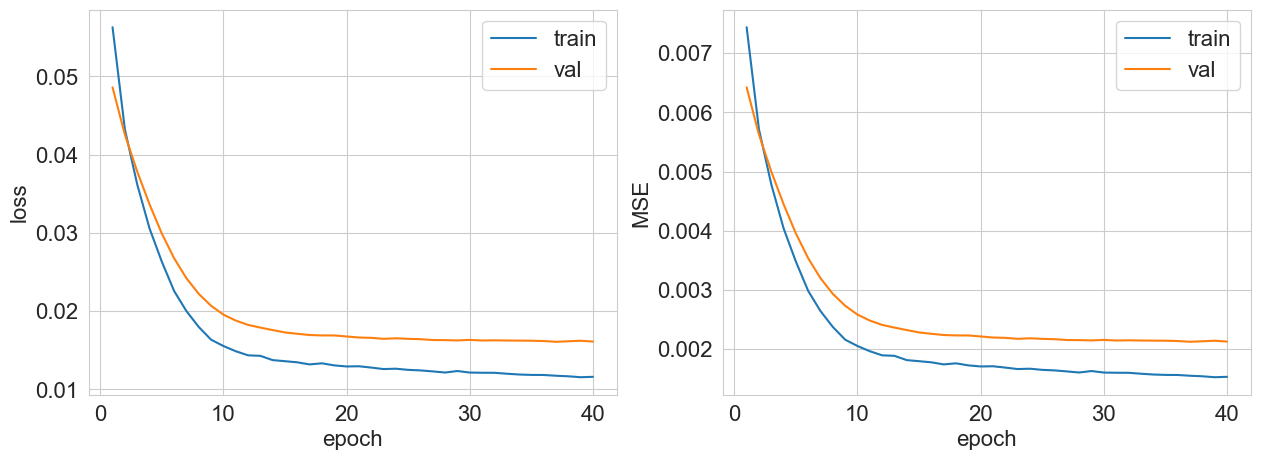

Validation MSE: 0.002


In [304]:
model = MLP()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.00001)
criterion = nn.MSELoss()
MSE = lambda y_pred, y_true: nn.MSELoss()(denormalize(y_pred), denormalize(y_true))
train_mse, test_mse = train_and_validate(model, optimizer, criterion, MSE, train_loader, test_loader,40, verbose = True)

In [305]:
from sklearn.metrics import mean_squared_error

test_mse**0.5

0.04613733686357341

In [306]:
test_mse

0.0021286538528628497

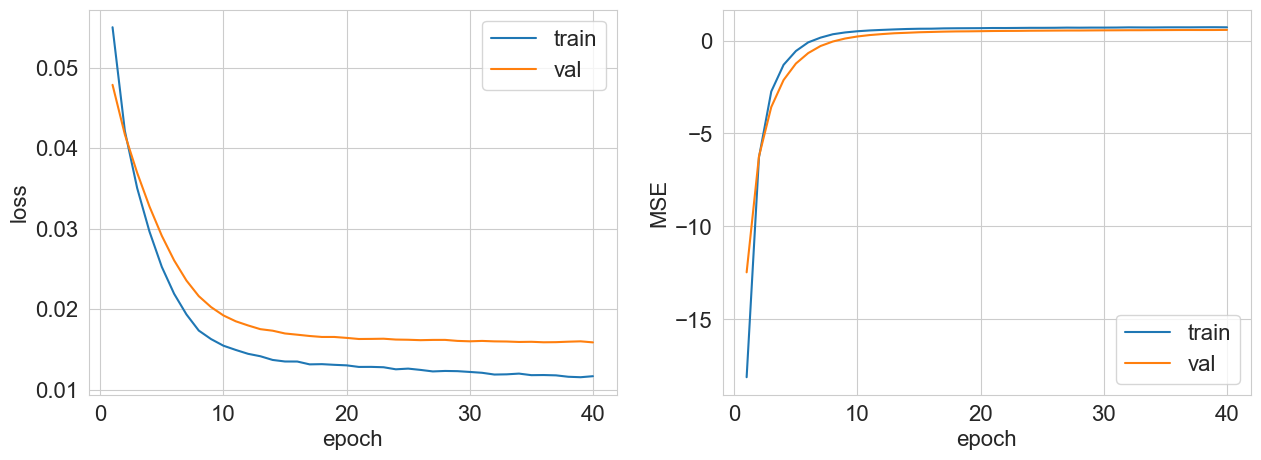

Validation MSE: 0.575


In [309]:
model = MLP()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.00001)
criterion = nn.MSELoss()
r2 = lambda y_pred, y_true: r2_score(denormalize(y_pred), denormalize(y_true))
train_r2, test_r2 = train_and_validate(model, optimizer, criterion, r2, train_loader, test_loader, 40, verbose = True)

In [310]:
test_r2

0.5747710089277567